In [26]:
# python基础包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from my_utils import DenseFeat, SparseFeat, VarLenSparseFeat

# 导入模型
from my_DIN import DIN

# 模型训练相关
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# 一些相关设置
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

2024-09-21 17:47:42.623858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 导入数据

In [28]:
"""读取数据"""
# 读取数据
samples_data = pd.read_csv("./data/movie_sample.txt", sep="\t", header = None)
samples_data.columns = ["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id", "label"]

In [29]:
"""数据集"""
X = samples_data[["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id"]]
y = samples_data["label"]
behavior_len = np.array([len([int(i) for i in l.split(',') if int(i) != 0]) for l in X['hist_movie_id']])

In [30]:
"""构建DIN模型的输入格式"""
X_train = {"user_id": np.array(X["user_id"]), \
            "gender": np.array(X["gender"]), \
            "age": np.array(X["age"]), \
            "hist_movie_id": np.array([[int(i) for i in l.split(',')] for l in X["hist_movie_id"]]), \
            "seq_length": behavior_len, \
            "hist_len": np.array(X["hist_len"]), \
            "movie_id": np.array(X["movie_id"]), \
            "movie_type_id": np.array(X["movie_type_id"])}
y_train = np.array(y)

### 模型建立

In [31]:
"""特征封装"""
feature_columns = [SparseFeat('user_id', max(samples_data["user_id"])+1, embedding_dim=8), 
                        SparseFeat('gender', max(samples_data["gender"])+1, embedding_dim=8), 
                        SparseFeat('age', max(samples_data["age"])+1, embedding_dim=8), 
                        SparseFeat('movie_id', max(samples_data["movie_id"])+1, embedding_dim=8),
                        SparseFeat('movie_type_id', max(samples_data["movie_type_id"])+1, embedding_dim=8),
                        DenseFeat('hist_len', 1)]

feature_columns += [VarLenSparseFeat(SparseFeat('hist_movie_id', 
                                                vocabulary_size=max(samples_data["movie_id"])+1,
                                                embedding_dim=8,
                                                embedding_name='item_id'), maxlen=50, length_name='seq_length')]

# 行为特征列表，表示的是基础特征
behavior_feature_list = ['movie_id']
# 行为序列特征
behavior_seq_feature_list = ['hist_movie_id']

In [32]:
"""设置超参数"""
learning_rate = 0.001
batch_size = 64
epochs = 50

In [33]:
"""构建DIN模型"""
model = DIN(feature_columns, behavior_feature_list, behavior_seq_feature_list)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_type_id       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_user_id         │ (None, 1, 8)      │         32 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_gender          │ (None, 1, 8)      │         24 │ gender[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_age (Embedding) │ (None, 1, 8)      │         32 │ age[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_movie_id        │ (None, 1, 8)      │      1,672 │ movie_id[0][0],   │
│ (Embedding)         │                   │            │ movie_id[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_movie_type_id   │ (None, 1, 8)      │         80 │ movie_type_id[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hist_movie_id       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ emb_user_id[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ emb_gender[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8)         │          0 │ emb_age[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 8)         │          0 │ emb_movie_id[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 8)         │          0 │ emb_movie_type_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_hist_movie_id   │ (None, 50, 8)     │      1,680 │ hist_movie_id[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_length          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hist_len            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 101,746 (397.45 KB)

 Trainable params: 101,746 (397.45 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=[AUC()])

### 模型训练

In [35]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)  # 调整学习率
]
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    validation_split=0.2, 
                    batch_size=batch_size,
                    callbacks = callbacks
                   )

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 337ms/step - auc: 0.5536 - loss: 1.1879 - val_auc: 0.4760 - val_loss: 0.6496 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - auc: 0.4644 - loss: 0.5933 - val_auc: 0.4864 - val_loss: 0.5525 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - auc: 0.5094 - loss: 0.4985 - val_auc: 0.4668 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - auc: 0.5194 - loss: 0.4904 - val_auc: 0.4695 - val_loss: 0.4690 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - auc: 0.5077 - loss: 0.4839 - val_auc: 0.1859 - val_loss: 0.4822 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - auc: 0.5566 - loss: 0.4346 - val_auc: 0.1554 - val_loss: 0.5112 - learning_rate: 0.0010
Epoch 7/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - auc: 0.6509 - loss: 0.4401
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.00000004749

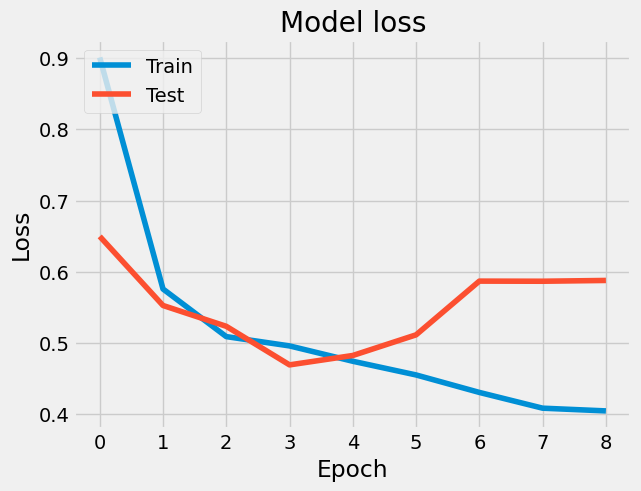

In [36]:
## """可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 模型架构可视化

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


python(48659) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


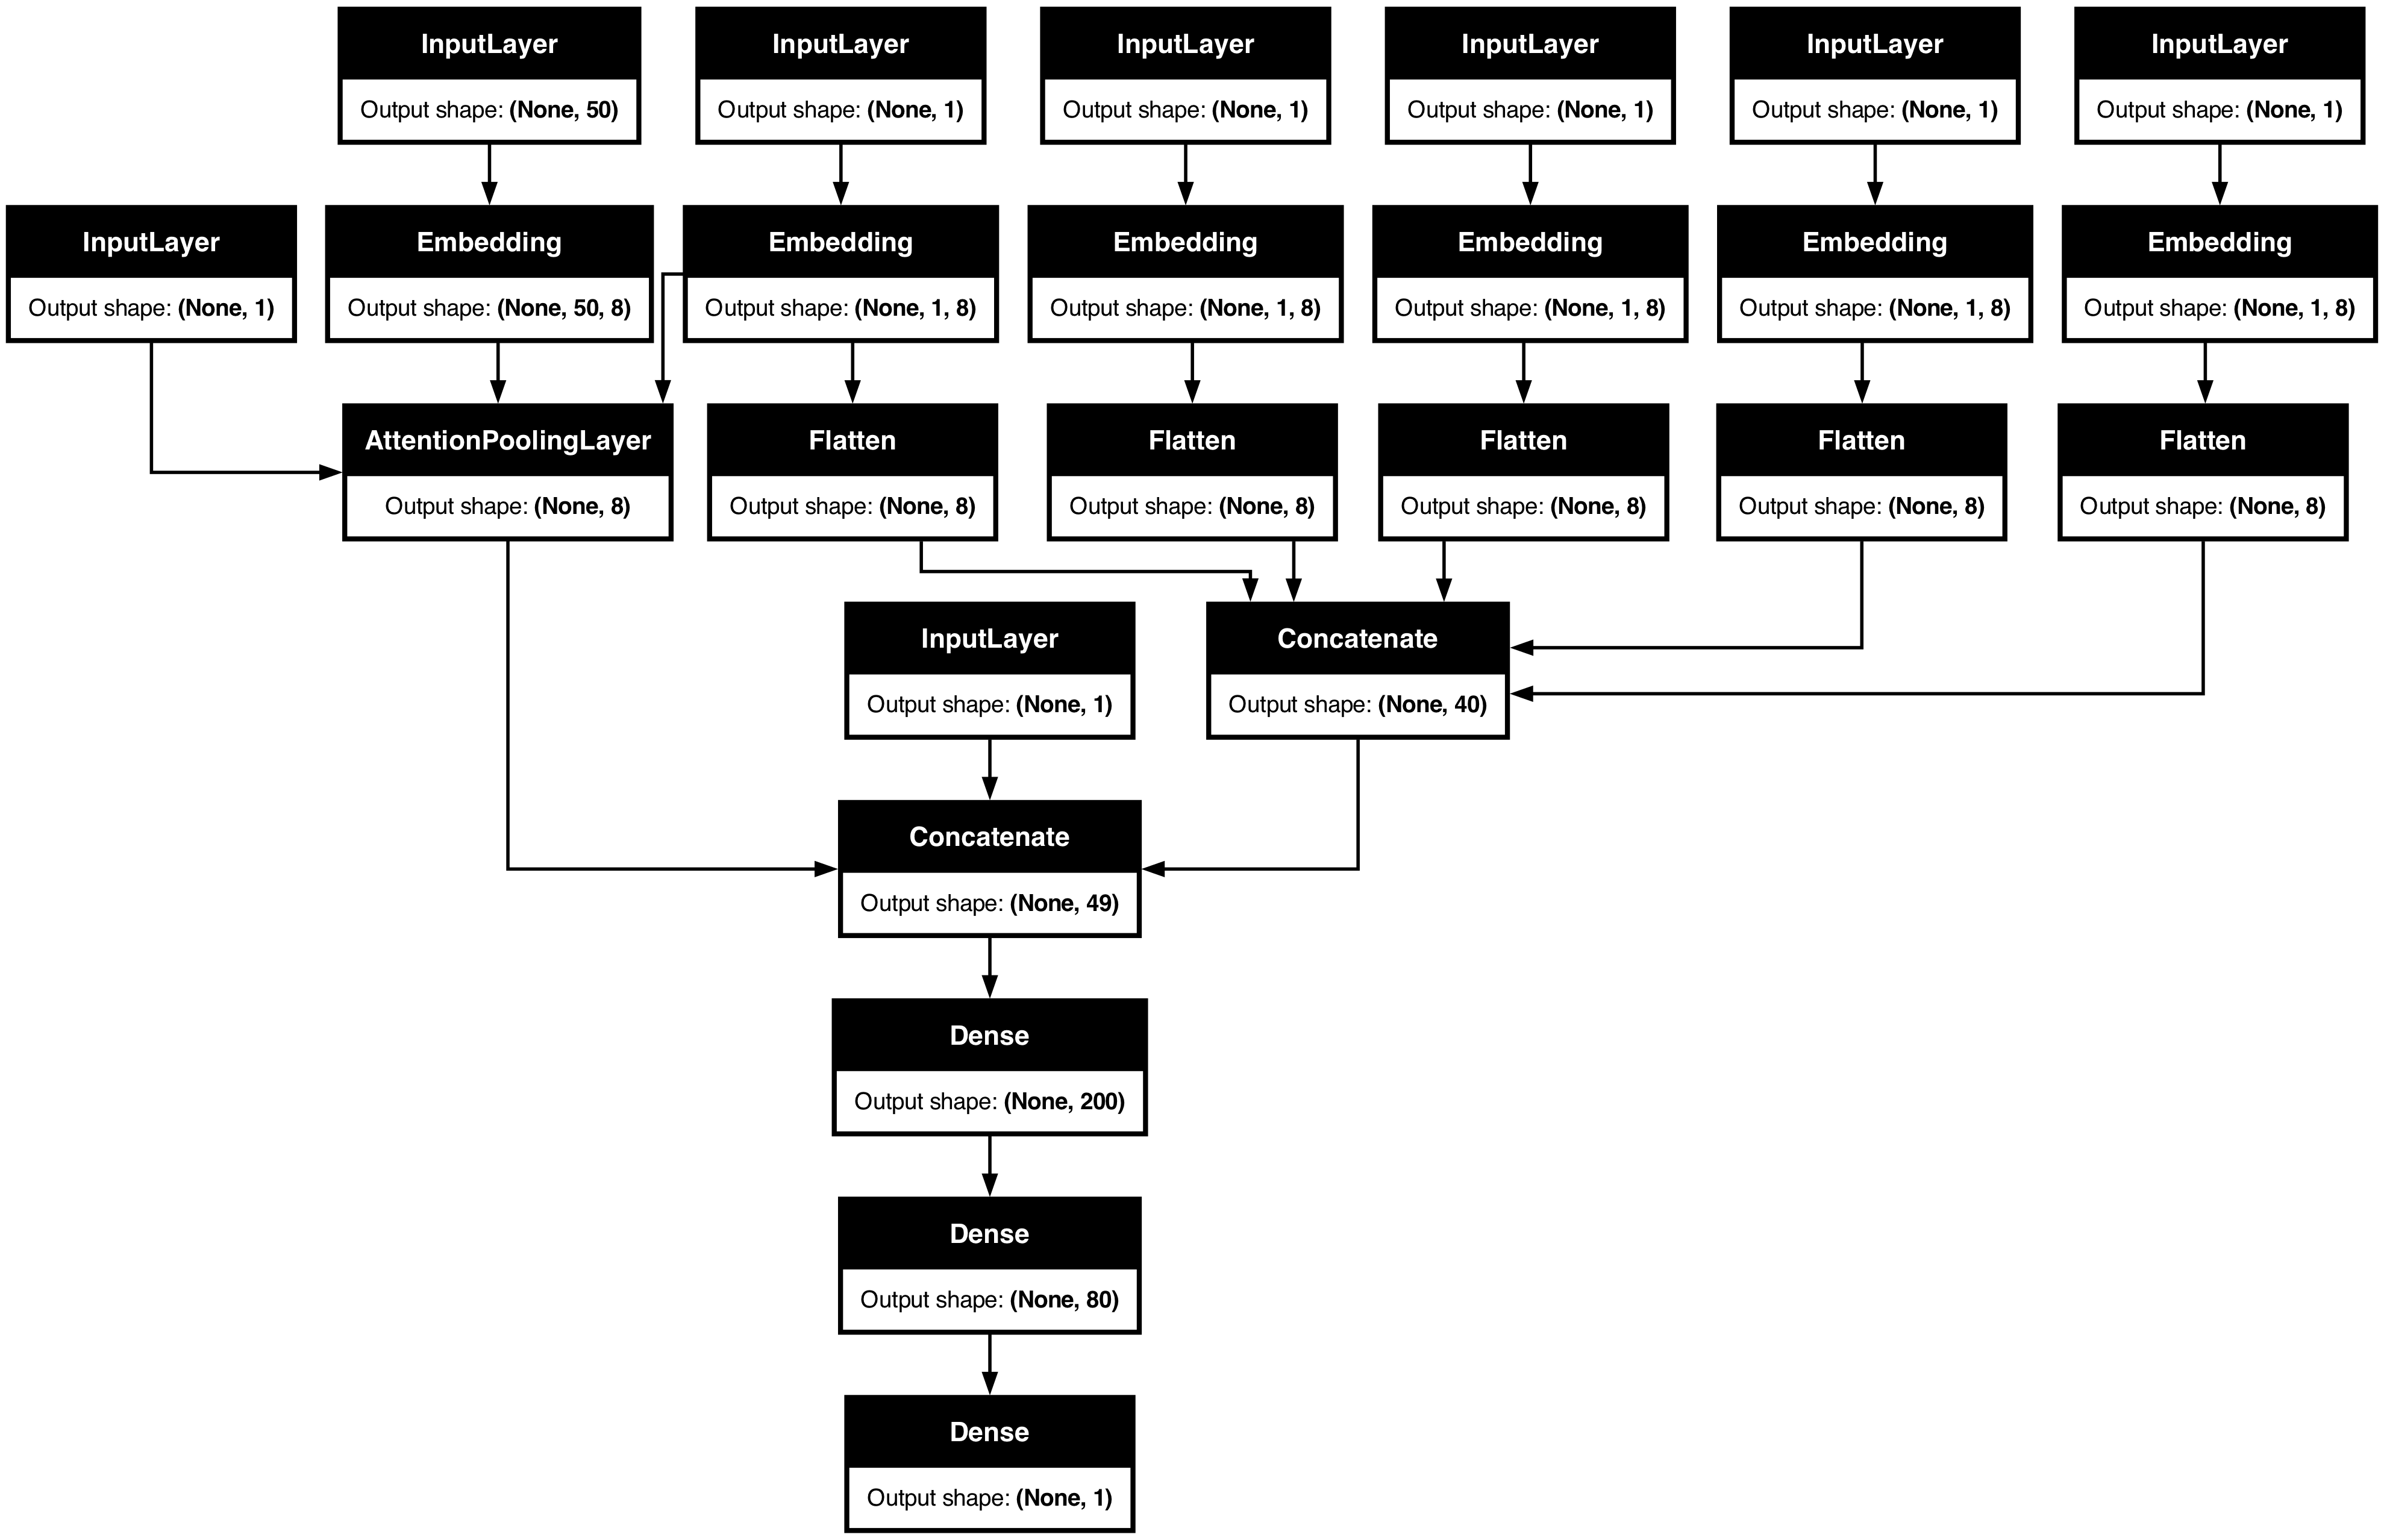

In [38]:
from tensorflow import keras
keras.utils.plot_model(model, to_file='./DIN_arc.png', show_shapes=True)